In [ ]:
'''Chatgpt Link: https://chatgpt.com/share/67b7029d-8ca0-8003-9667-0636da234d9c'''

In [ ]:
'''    1. Multi-Scale Morphological Segmentation for Satellite Image Enhancement
    • Implement multi-scale morphological filtering for terrain segmentation.
        ◦  Apply small SE for fine details (e.g., roads, buildings).
        ◦ Apply large SE for coarse structures (e.g., forests, rivers).
        ◦ Merge results using weighted fusion.
    • Use adaptive structuring elements to process different landscapes.
    •  Urban Areas → Use rectangular SEs (aligned with buildings).
    •  Forests & Vegetation → Use circular SEs (preserve tree clusters).
    •  Mountains & Hills → Use elliptical SEs (capture sloped terrains).
    • Water Bodies → Use disk-shaped SEs (eliminate boundary noise).'''

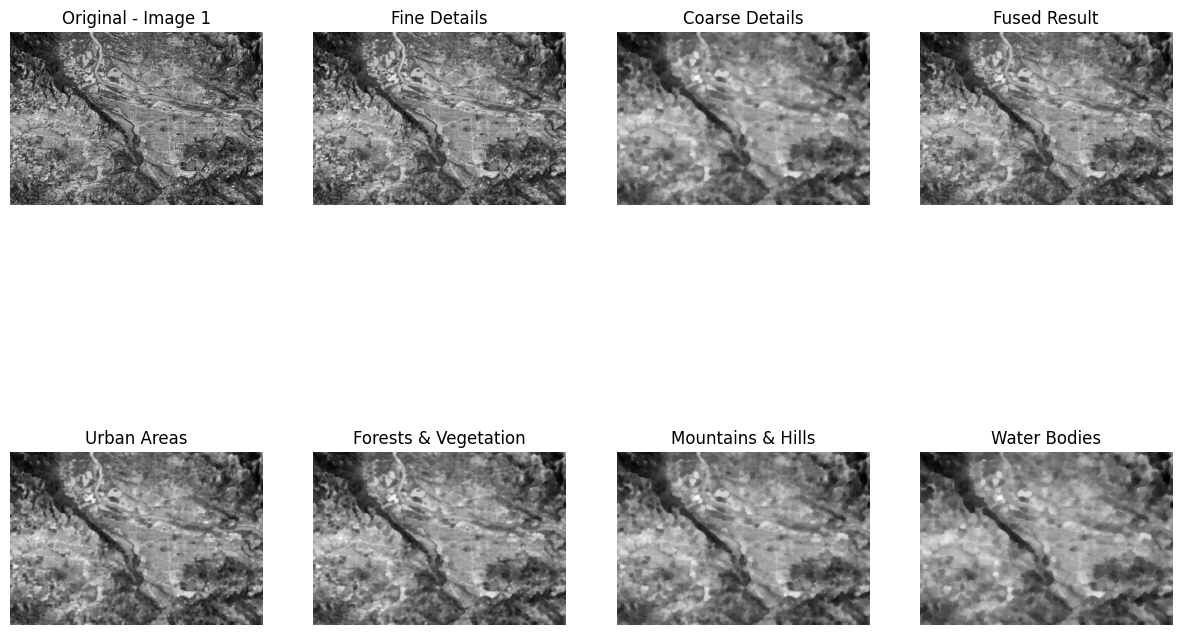

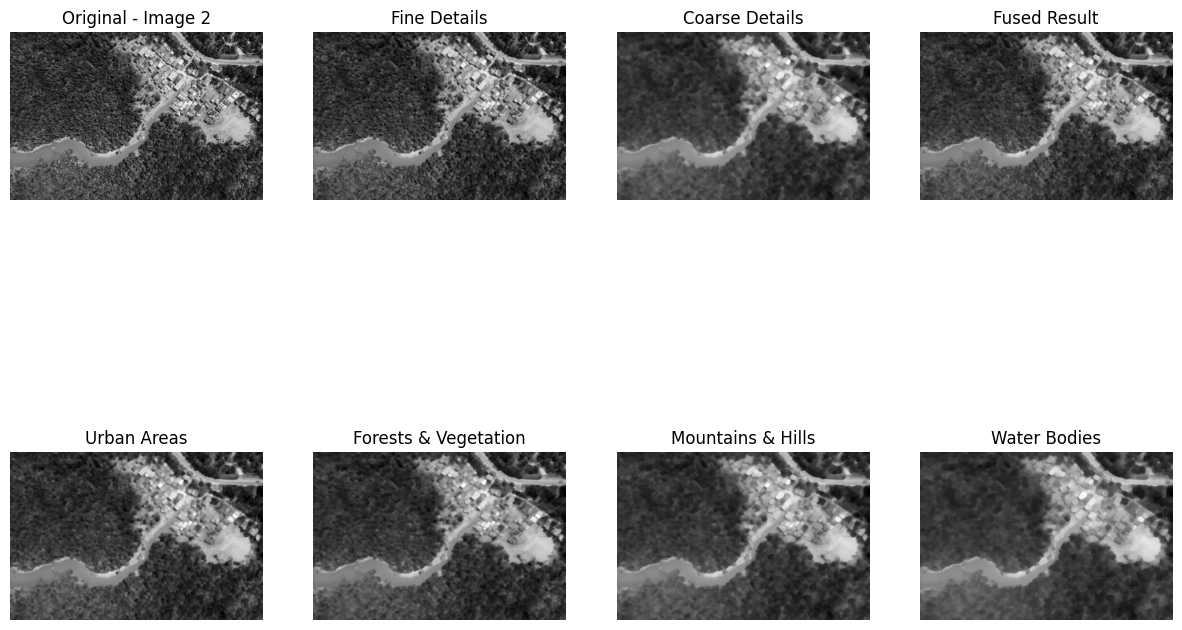

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def apply_morphology(image, kernel_size, shape):
    if shape == 'rect':
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
    elif shape == 'ellipse':
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    elif shape == 'disk':
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    else:  # Default to circular
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    
    opened = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
    closed = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    return cv2.addWeighted(opened, 0.5, closed, 0.5, 0)

def highlight_regions(image):
    urban = apply_morphology(image, 5, 'rect')
    forests = apply_morphology(image, 7, 'disk')
    mountains = apply_morphology(image, 9, 'ellipse')
    waterbodies = apply_morphology(image, 11, 'disk')
    
    return urban, forests, mountains, waterbodies

def process_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    fine_details = apply_morphology(image, 3, 'rect')  # Small kernel for roads/buildings
    coarse_details = apply_morphology(image, 9, 'ellipse')  # Large kernel for forests/rivers
    
    fused_result = cv2.addWeighted(fine_details, 0.5, coarse_details, 0.5, 0)
    
    urban, forests, mountains, waterbodies = highlight_regions(image)
    
    return image, fine_details, coarse_details, fused_result, urban, forests, mountains, waterbodies

# Load and process images
image1_path = '/home/student/Downloads/sat2.jpg' # Change with actual image path
image2_path = '/home/student/Downloads/sat1.jpg'

original1, fine1, coarse1, fused1, urban1, forests1, mountains1, waterbodies1 = process_image(image1_path)
original2, fine2, coarse2, fused2, urban2, forests2, mountains2, waterbodies2 = process_image(image2_path)

# Display results
def show_results(original, fine, coarse, fused, urban, forests, mountains, waterbodies, title):
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 4, 1)
    plt.imshow(original, cmap='gray')
    plt.title(f'Original - {title}')
    plt.axis('off')
    
    plt.subplot(2, 4, 2)
    plt.imshow(fine, cmap='gray')
    plt.title('Fine Details')
    plt.axis('off')
    
    plt.subplot(2, 4, 3)
    plt.imshow(coarse, cmap='gray')
    plt.title('Coarse Details')
    plt.axis('off')
    
    plt.subplot(2, 4, 4)
    plt.imshow(fused, cmap='gray')
    plt.title('Fused Result')
    plt.axis('off')
    
    plt.subplot(2, 4, 5)
    plt.imshow(urban, cmap='gray')
    plt.title('Urban Areas')
    plt.axis('off')
    
    plt.subplot(2, 4, 6)
    plt.imshow(forests, cmap='gray')
    plt.title('Forests & Vegetation')
    plt.axis('off')
    
    plt.subplot(2, 4, 7)
    plt.imshow(mountains, cmap='gray')
    plt.title('Mountains & Hills')
    plt.axis('off')
    
    plt.subplot(2, 4, 8)
    plt.imshow(waterbodies, cmap='gray')
    plt.title('Water Bodies')
    plt.axis('off')
    
    plt.show()

show_results(original1, fine1, coarse1, fused1, urban1, forests1, mountains1, waterbodies1, 'Image 1')
show_results(original2, fine2, coarse2, fused2, urban2, forests2, mountains2, waterbodies2, 'Image 2')


In [ ]:
'''    2. Dynamic Graph-Based Image Segmentation with Adaptive Edge Weights
    • Implement a graph-based segmentation algorithm that dynamically updates edge weights based on local contrast.
    • Use a self-learning mechanism to refine segment boundaries iteratively.
      3models, spectral, min cut, normalised cut'''

/home/student/.local/lib/python3.10/site-packages/skimage/segmentation/_expand_labels.py:2: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 1.23.3)
  from scipy.ndimage import distance_transform_edt
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:374: UserWarning: Exited postprocessing with accuracies 
[1.12765038e-15 8.61790539e-06 1.00812955e-05]
not reaching the requested tolerance 1e-05.
  _, diffusion_map = lobpcg(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:298: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  _, diffusion_map = eigsh(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:298: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  _, diffusion_map = eigsh(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embeddin

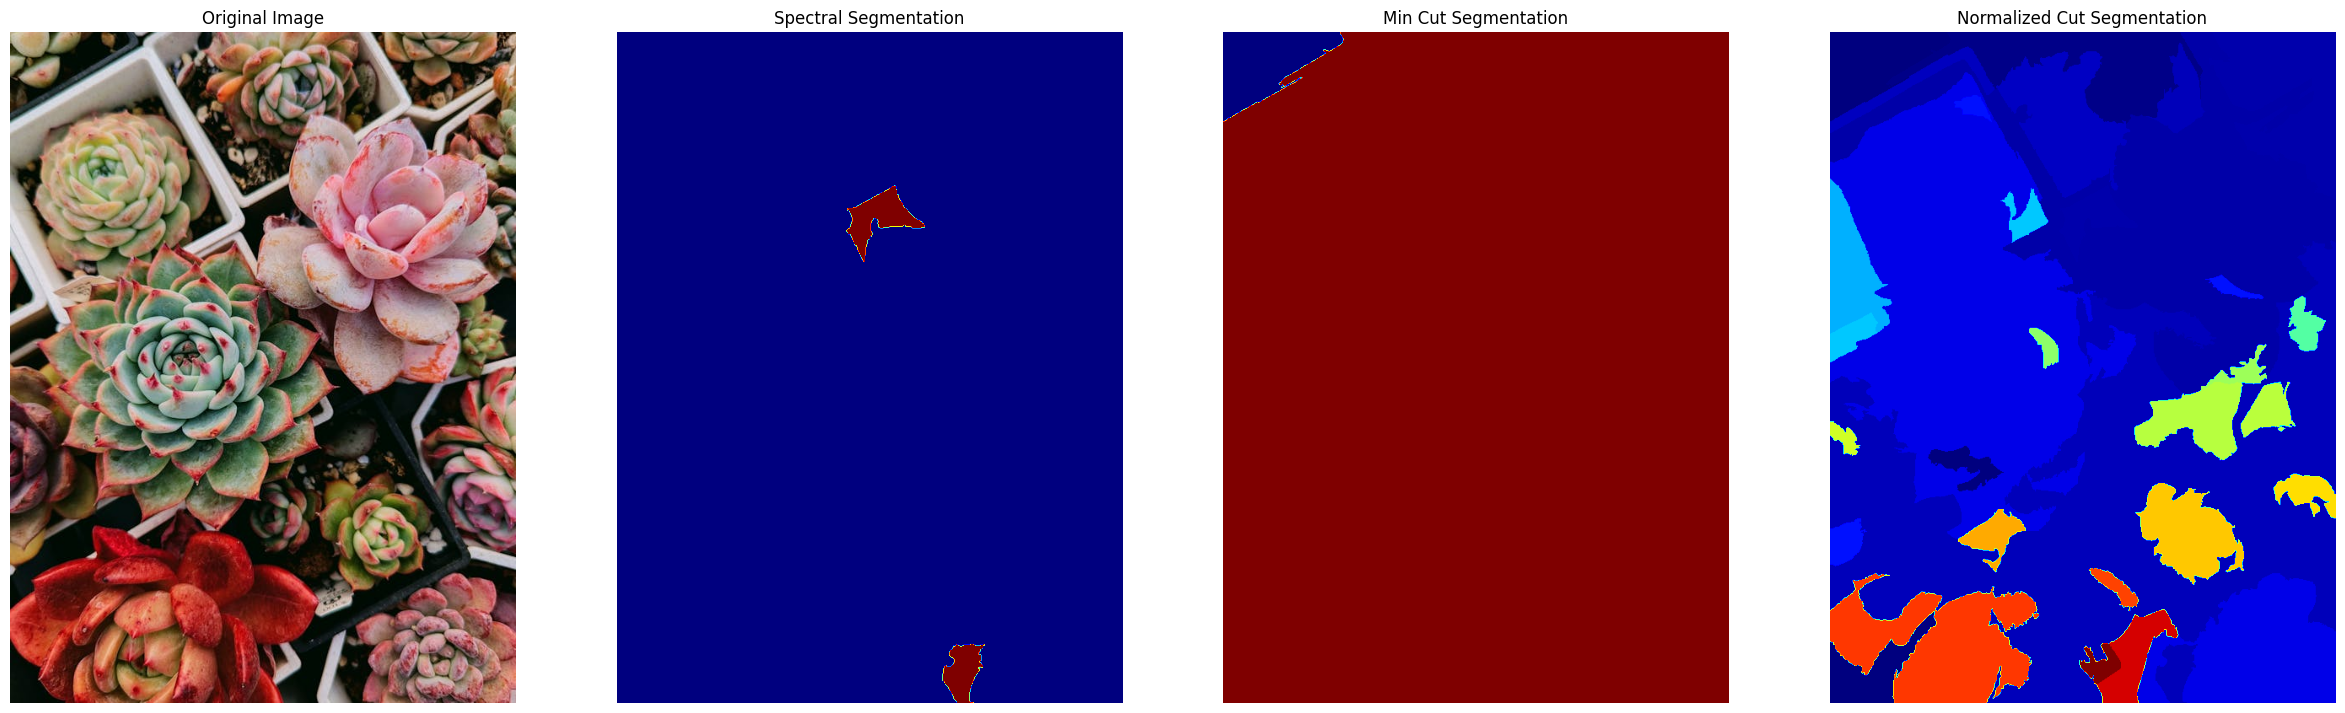

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import slic
from skimage import graph
import networkx as nx
from sklearn.cluster import SpectralClustering

def spectral_segmentation(labels, rag, n_clusters=2):
    """
    Build an affinity matrix from the RAG and apply spectral clustering.
    """
    n_regions = labels.max() + 1
    W = np.zeros((n_regions, n_regions))
    
    # Build symmetric affinity matrix using edge weights from the RAG.
    for (i, j, data_dict) in rag.edges(data=True):
        weight = data_dict.get('weight', 0)
        W[i, j] = weight
        W[j, i] = weight
    
    # Spectral clustering with precomputed affinity matrix.
    sc = SpectralClustering(n_clusters=n_clusters, affinity='precomputed',
                            assign_labels='discretize', random_state=0)
    region_labels = sc.fit_predict(W)
    
    # Map region labels back to pixel labels.
    new_labels = np.copy(labels)
    for region in range(n_regions):
        new_labels[labels == region] = region_labels[region]
    
    return new_labels

def min_cut_segmentation(labels, rag, image):
    """
    Use NetworkX's minimum cut to partition the graph.
    The source is set as the region with the lowest mean intensity and the sink as the region with the highest mean intensity.
    """
    # Convert image to grayscale for intensity computation.
    # Image is assumed to be in RGB.
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    n_regions = labels.max() + 1
    region_means = np.zeros(n_regions)
    
    for r in range(n_regions):
        region_pixels = gray[labels == r]
        region_means[r] = np.mean(region_pixels)
    
    # Designate source and sink based on mean intensities.
    source = int(np.argmin(region_means))
    sink = int(np.argmax(region_means))
    
    # Compute minimum cut on the RAG using edge weights as capacities.
    cut_value, partition = nx.minimum_cut(rag, source, sink, capacity='weight')
    reachable, non_reachable = partition
    
    # Assign label 0 to nodes in the reachable set, and label 1 to the rest.
    new_labels = np.copy(labels)
    for r in range(n_regions):
        if r in reachable:
            new_labels[labels == r] = 0
        else:
            new_labels[labels == r] = 1
            
    return new_labels

def iterative_segmentation(image, method='spectral', n_iter=5):
    """
    Iteratively refine the segmentation by:
      1. Computing SLIC superpixels.
      2. Building a RAG with adaptive (contrast-based) edge weights.
      3. Updating region labels using the specified method.
    
    Supported methods: 'spectral', 'min_cut', 'normalized_cut'
    """
    # Initial superpixel segmentation.
    labels = slic(image, n_segments=400, start_label=0)
    
    for i in range(n_iter):
        # Build a region adjacency graph based on mean color similarity.
        rag = graph.rag_mean_color(image, labels, mode='similarity')
        
        # Update segmentation based on chosen method.
        if method == 'spectral':
            new_labels = spectral_segmentation(labels, rag, n_clusters=2)
        elif method == 'min_cut':
            new_labels = min_cut_segmentation(labels, rag, image)
        elif method == 'normalized_cut':
            # Using the built-in normalized cut from skimage.
            new_labels = graph.cut_normalized(labels, rag)
        else:
            raise ValueError("Unsupported method. Choose spectral, min_cut, or normalized_cut.")
        
        # Stop if segmentation does not change.
        if np.array_equal(new_labels, labels):
            break
        labels = new_labels
    return labels

def display_segmentation_results(image, spectral_labels, min_cut_labels, normalized_cut_labels):
    """
    Display the original image and the three segmentation outputs in a large figure.
    """
    plt.figure(figsize=(30, 10))
    
    plt.subplot(1, 4, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")
    
    plt.subplot(1, 4, 2)
    plt.imshow(spectral_labels, cmap='jet')
    plt.title("Spectral Segmentation")
    plt.axis("off")
    
    plt.subplot(1, 4, 3)
    plt.imshow(min_cut_labels, cmap='jet')
    plt.title("Min Cut Segmentation")
    plt.axis("off")
    
    plt.subplot(1, 4, 4)
    plt.imshow(normalized_cut_labels, cmap='jet')
    plt.title("Normalized Cut Segmentation")
    plt.axis("off")
    
    plt.show()

if __name__ == '__main__':
    # Set the path to your input image directly here.
    image_path = '/home/student/Downloads/test.jpeg' # <-- Update with your image path
    
    # Read the image using OpenCV.
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Unable to load image from", image_path)
        exit()
    
    # Convert image from BGR to RGB for correct display.
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Run iterative segmentation for each model.
    spectral_labels = iterative_segmentation(image, method='spectral', n_iter=5)
    min_cut_labels = iterative_segmentation(image, method='min_cut', n_iter=5)
    normalized_cut_labels = iterative_segmentation(image, method='normalized_cut', n_iter=5)
    
    # Display the results.
    display_segmentation_results(image, spectral_labels, min_cut_labels, normalized_cut_labels)
    
    # Optionally, save the segmentation outputs.
    cv2.imwrite("spectral_segmentation.jpg", (spectral_labels / np.max(spectral_labels) * 255).astype(np.uint8))
    cv2.imwrite("min_cut_segmentation.jpg", (min_cut_labels / np.max(min_cut_labels) * 255).astype(np.uint8))
    cv2.imwrite("normalized_cut_segmentation.jpg", (normalized_cut_labels / np.max(normalized_cut_labels) * 255).astype(np.uint8))


In [ ]:
'''    3. Morphological Hit-or-Miss Transform for Document Forgery Detection
    • Implement hit-or-miss transform to detect forgery marks in scanned documents.
    • Design custom structuring elements for common fraud patterns.
    • Rupee, picture, fake or real note, identify forgery marks. Compare and mark the region of fake in the image.
'''

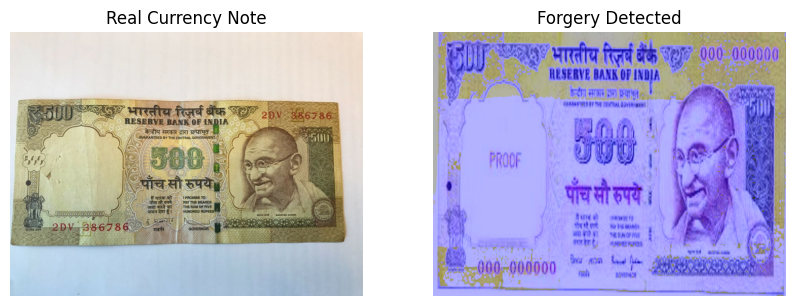

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_forgery(real_img, fake_img):
    """Detects forged areas and highlights them in red."""
    
    # Resize images to match dimensions
    if real_img.shape != fake_img.shape:
        fake_img = cv2.resize(fake_img, (real_img.shape[1], real_img.shape[0]))

    # Convert to grayscale
    real_gray = cv2.cvtColor(real_img, cv2.COLOR_BGR2GRAY)
    fake_gray = cv2.cvtColor(fake_img, cv2.COLOR_BGR2GRAY)
    
    # Compute absolute difference to detect altered areas
    forgery_mask = cv2.absdiff(real_gray, fake_gray)

    # Apply threshold to highlight significant differences
    _, forgery_mask = cv2.threshold(forgery_mask, 30, 255, cv2.THRESH_BINARY)

    # Apply morphological operations to enhance forgery regions
    kernel = np.ones((3,3), np.uint8)
    forgery_mask = cv2.dilate(forgery_mask, kernel, iterations=2)

    # Convert the mask to a 3-channel image for overlay
    forgery_mask_color = cv2.cvtColor(forgery_mask, cv2.COLOR_GRAY2BGR)
    forgery_mask_color[:, :, 1:] = 0  # Keep only the red channel

    # Overlay the forgery mask on the fake image
    fake_marked = cv2.addWeighted(fake_img, 0.7, forgery_mask_color, 0.6, 0)

    return fake_marked

# Load images (Replace with actual image paths)
real_image = cv2.imread('/home/student/Downloads/real.jpg')
fake_image = cv2.imread('/home/student/Downloads/fake2.jpeg')

# Check if images are loaded properly
if real_image is None or fake_image is None:
    print("Error: Could not load images. Check file paths.")
    exit()

# Detect forgery
marked_forgery = detect_forgery(real_image, fake_image)

# Display results
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(real_image, cv2.COLOR_BGR2RGB))
plt.title("Real Currency Note")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(marked_forgery, cv2.COLOR_BGR2RGB))
plt.title("Forgery Detected")
plt.axis("off")

plt.show()


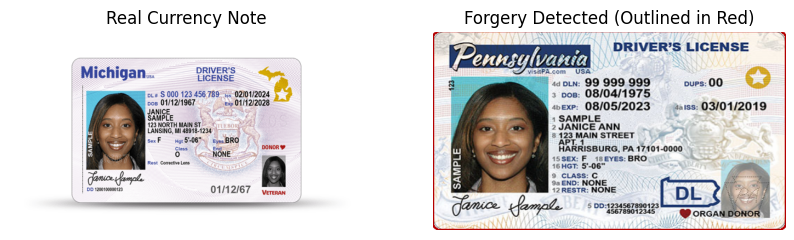

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_forgery_with_border(real_img, fake_img):
    """Detects forged areas and highlights them with a soft red border."""
    
    # Resize fake image to match real image dimensions
    if real_img.shape != fake_img.shape:
        fake_img = cv2.resize(fake_img, (real_img.shape[1], real_img.shape[0]))

    # Convert images to grayscale
    real_gray = cv2.cvtColor(real_img, cv2.COLOR_BGR2GRAY)
    fake_gray = cv2.cvtColor(fake_img, cv2.COLOR_BGR2GRAY)
    
    # Compute absolute difference (Forgery Detection)
    forgery_mask = cv2.absdiff(real_gray, fake_gray)

    # Apply threshold to focus on significant differences
    _, forgery_mask = cv2.threshold(forgery_mask, 30, 255, cv2.THRESH_BINARY)

    # Apply morphological operations to enhance forgery regions
    kernel = np.ones((3, 3), np.uint8)
    forgery_mask = cv2.dilate(forgery_mask, kernel, iterations=2)

    # Find contours of forged regions
    contours, _ = cv2.findContours(forgery_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw a soft red border around forged areas
    fake_marked = fake_img.copy()
    cv2.drawContours(fake_marked, contours, -1, (0, 0, 180), 2)  # Soft red border

    return fake_marked

# Load images (Replace with actual image paths)
real_image = cv2.imread('/home/student/Downloads/real1.png')
fake_image = cv2.imread('/home/student/Downloads/fake2.jpg')

# Check if images are loaded properly
if real_image is None or fake_image is None:
    print("Error: Could not load images. Check file paths.")
    exit()

# Detect forgery and highlight with a border
marked_forgery = detect_forgery_with_border(real_image, fake_image)

# Display results
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(real_image, cv2.COLOR_BGR2RGB))
plt.title("Real Currency Note")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(marked_forgery, cv2.COLOR_BGR2RGB))
plt.title("Forgery Detected (Outlined in Red)")
plt.axis("off")

plt.show()
